In [1]:
# import modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("bright")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

C:\Users\Daniil\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Exploration

In [2]:
data = pd.read_excel("Company_HR_Employees.xlsx")

In [3]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,2068,2,...,1,80,0,6,3,4,4,3,1,2
1,49,No,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,...,4,80,0,17,3,2,9,6,0,8
2,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,...,2,80,1,6,0,3,6,2,0,3
3,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,...,1,80,1,9,5,3,7,7,1,7
4,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,...,3,80,1,17,3,3,5,2,0,3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [5]:
print(data["Over18"].value_counts(), data["StandardHours"].value_counts(), sep="\n")

Y    1470
Name: Over18, dtype: int64
80    1470
Name: StandardHours, dtype: int64


#### Over18 and StandardHours consist of only one unique value, so there is no reason to keep them.

In [6]:
# drop selected columns
data.drop(["Over18", "StandardHours"], axis=1, inplace=True)

#### Column Attrition should be one-hot encoded to continue exploration.

In [7]:
data["Attrition"] = [1 if x=="Yes" else 0 for x in data["Attrition"]]

# Data Analysis

#### Lets plot the distribution of numeric columns in our data for better understanding

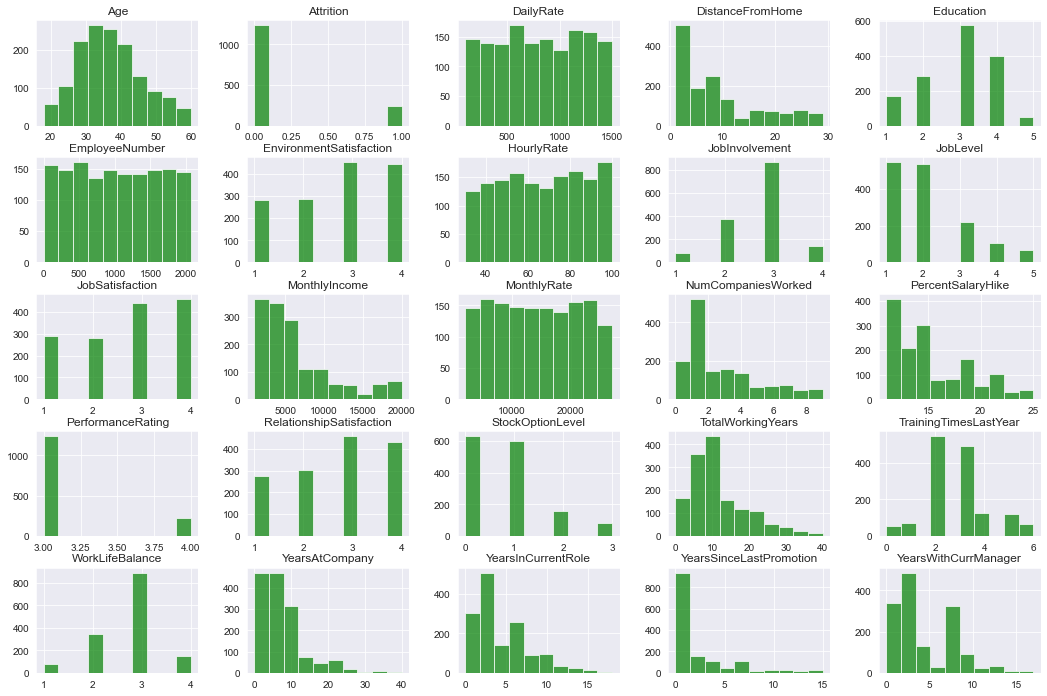

In [8]:
data.hist(figsize=(18, 12), color="g", alpha=0.7);

In [43]:
# define a function to plot important things easier
def plot_hist(data, x, hue, title="", kde=False):
    """
    Plots histograms on selected data
    
    ...
    
    Parameters
    ----------
    data : pd.DataFrame
        Data to plot
    x : str
        Column to plot
    hue : str
        Feature to groupby
    title : str
        Title to show on the plot
    kde : bool 
        Show / hide kde
    """
    
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data, x=x, hue=hue, kde=kde)
    plt.title(title, fontsize=14)
    plt.xticks(fontsize=12)

#### Plot Attrition by Department, JobLevel, Gender, JobRole

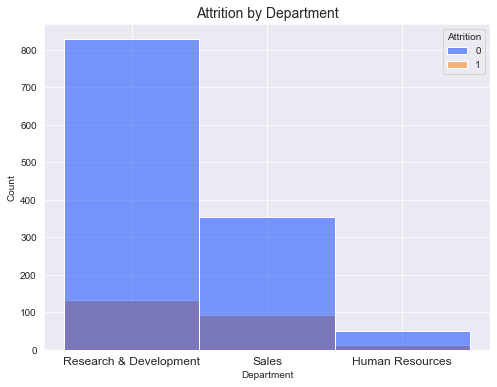

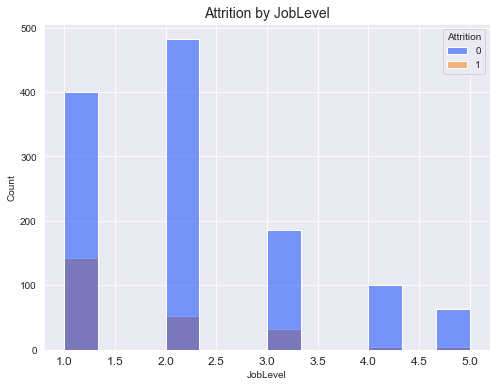

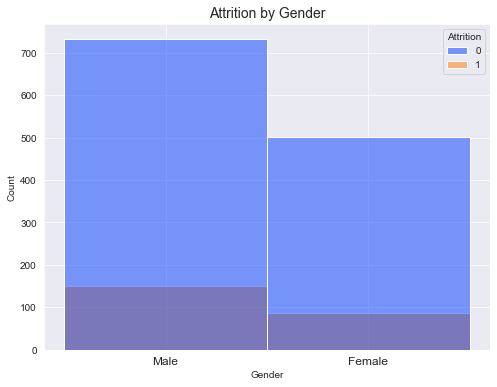

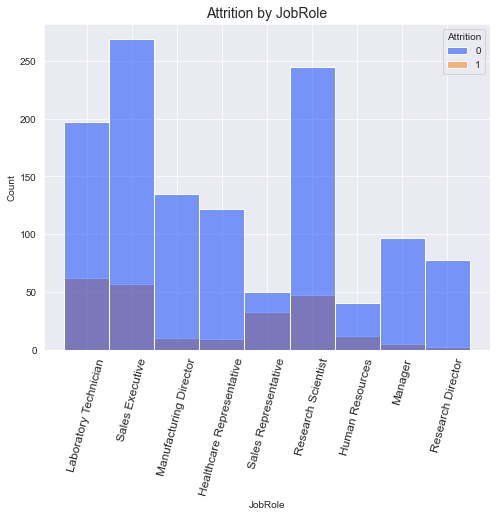

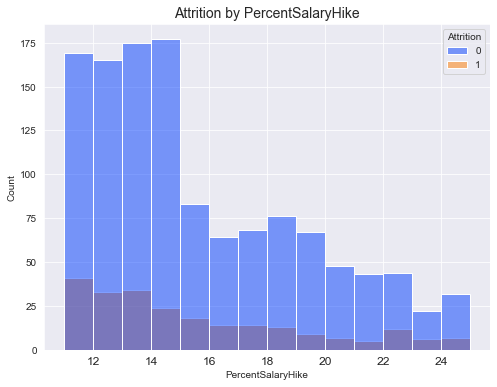

In [10]:
for feature in ["Department", "JobLevel", "Gender", "JobRole", "PercentSalaryHike"]:
    plot_hist(data, feature, "Attrition", title=f"Attrition by {feature}")
    if feature == "JobRole":
        plt.xticks(rotation=75)

#### Calculate the percentage of employees with attrition divided by Gender

In [11]:
# select male and female subsets
male = data[data["Gender"] == "Male"]
female = data[data["Gender"] == "Female"]

print("Male Attrition:", round((len(male[male["Attrition"] == 1])) / (len(male)) * 100, 3), "%")
print("Female Attrition:", round((len(female[female["Attrition"] == 1])) / (len(female)) * 100, 3), "%")

Male Attrition: 17.007 %
Female Attrition: 14.796 %


#### Plot TotalWorkingYears, Age, MonthlyIncome by Gender

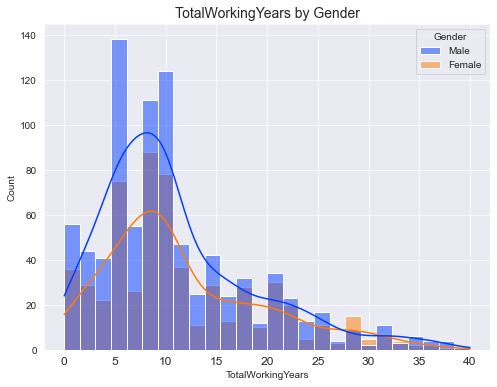

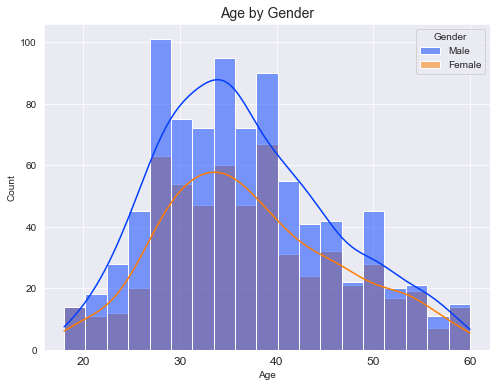

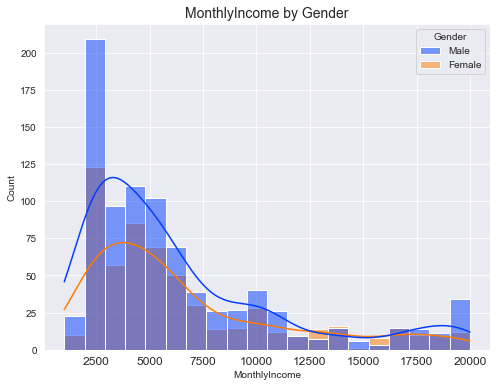

In [12]:
for feature in ["TotalWorkingYears", "Age", "MonthlyIncome"]:
    plot_hist(data, feature, "Gender", title=f"{feature} by Gender", kde=True)

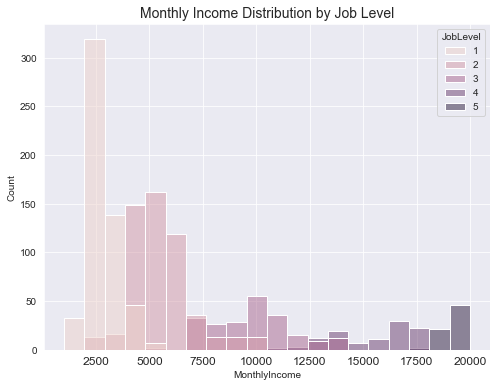

In [13]:
# plot correlation between income and job level
plot_hist(data, "MonthlyIncome", "JobLevel", "Monthly Income Distribution by Job Level")

#### Lets plot Correlation Matrix to find all correlations of our data

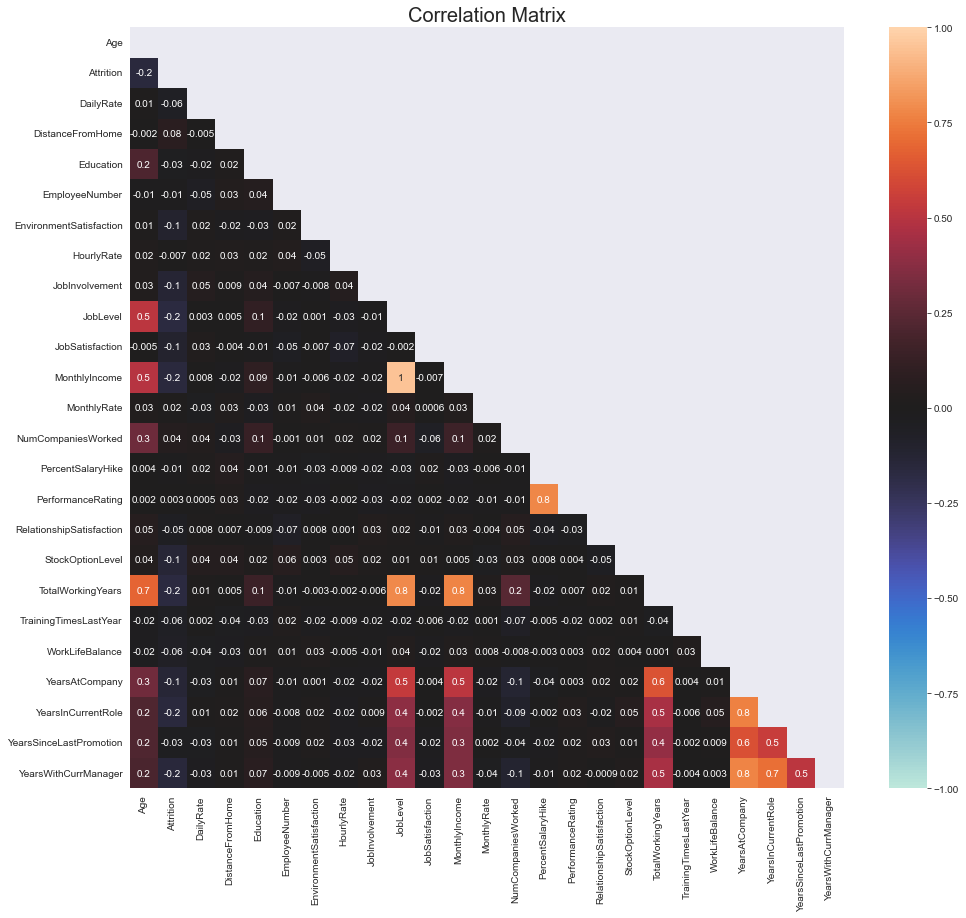

In [14]:
# create mask to hide upper part om matrix
matrix = np.triu(data.corr())
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(data.corr(), annot=True, ax=ax, vmin=-1, vmax=1, center= 0, fmt=".1g", mask=matrix)  # apply mask
plt.title("Correlation Matrix", fontsize=20);

#### On the Matrix we can see some important correlations like:

* MonthlyIncome with JobLevel at 1, what is a complete maximum;

* JobLevel, MonthlyIncome, TotalWorkingYears correlate with Age, what can be described as "The older the worker - the more experience he has (and salary)";

* NumCompaniesWorked, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager correlates with “Age”, as like the previous features. We should consider an older employee a more experienced one with huge working background;

* PerformanceRanting correlates with PercentSalaryHike at 0.8, what states for good bonuses for good productivity;

* TotalWorkingYears correlates JobLevel and MonthlyIncome, what can be considered as - the more you work for the company - the more benefits like huge salary or leading role you will achieve.

#### In the right bottom corner we can notice an interesting correlation of time spend in company/corrent_role with time spend with cirrent manager. Moreover, YearsSinceLastPromotion correlates with YearsWithCurrManager. Some interesting correlations to investigate further.

In [44]:
# define a function to plot bar_plot and compare employees
def plot_bar(data, x, y, title=""):
    """
    Plots bar charts on selected data
    
    ...
    
    Parameters
    ----------
    data : pd.DataFrame
        Data to plot
    x : str
        Column to plot on x
    y : str
        Column to plot on y
    title : str
        Title to show on the plot
    """
    
    plt.figure(figsize=(16, 8))
    sns.barplot(data=data, x=x, y=y)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=65, fontsize=12)

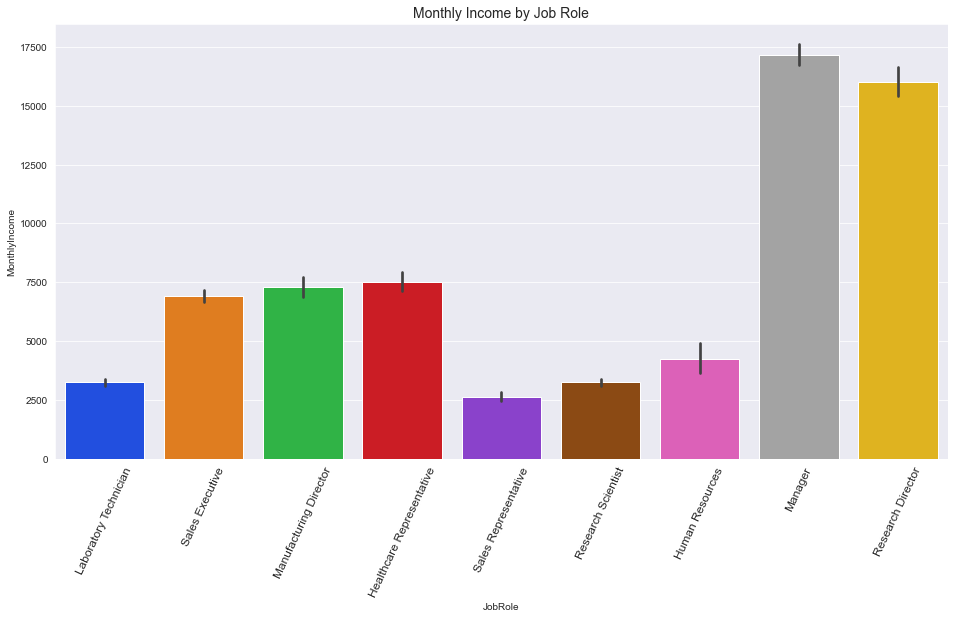

In [16]:
plot_bar(data, "JobRole", "MonthlyIncome", "Monthly Income by Job Role")

#### Lets plot and compare some important features connected with attrition

In [17]:
# define two subsets for attrition and non-attrition workers
attrition = data[data["Attrition"] == 1]
non_attrition = data[data["Attrition"] == 0]

# decide what columns to plot
numeric_data_to_plot = ["Age", "DistanceFromHome", 
                        "MonthlyIncome", "HourlyRate", 
                        "JobInvolvement", "PercentSalaryHike", 
                        "DailyRate", "TotalWorkingYears", 
                        "YearsAtCompany"]

In [45]:
# define function to plot correlation of numeric columns with attrition
def plot_num_data(column):
    """
    Plots numeric data correlation with attrition
    
    ...
    
    Parameters
    ----------
    column : str
        Column to plot
    """
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(attrition[column], label="Attrition", shade=True, color="r")
    sns.kdeplot(non_attrition[column], label="Non-Attrition", shade=True, color="g")
    plt.title(f"{column} Distibution", fontsize=14)
    plt.xticks(fontsize=12)
    plt.legend()

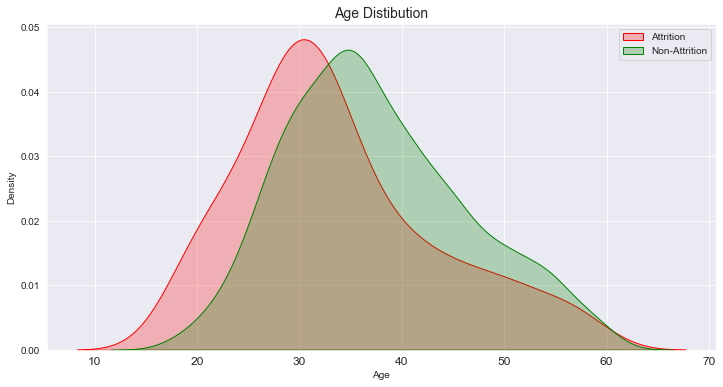

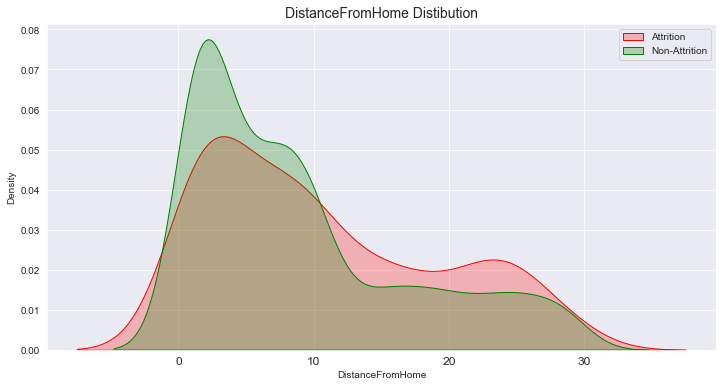

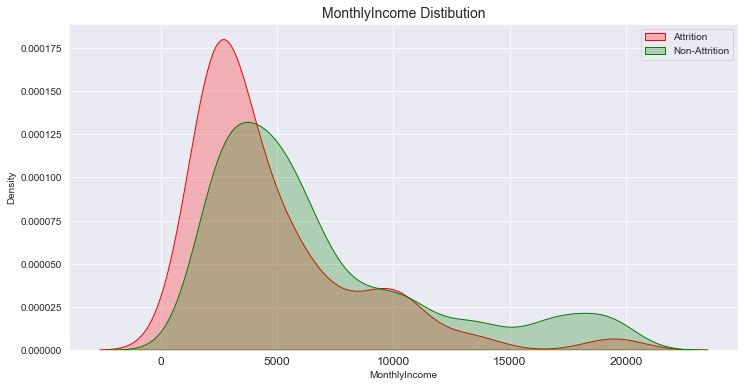

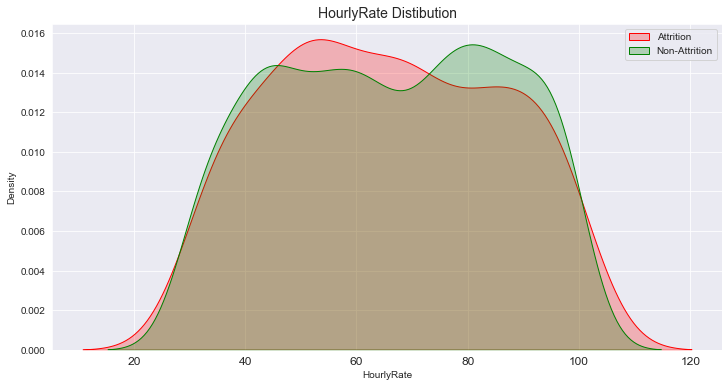

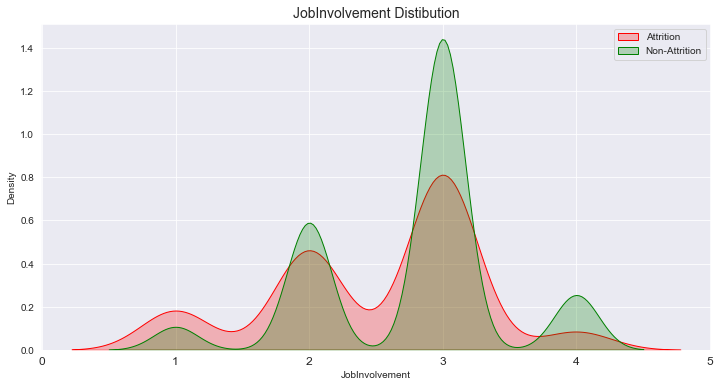

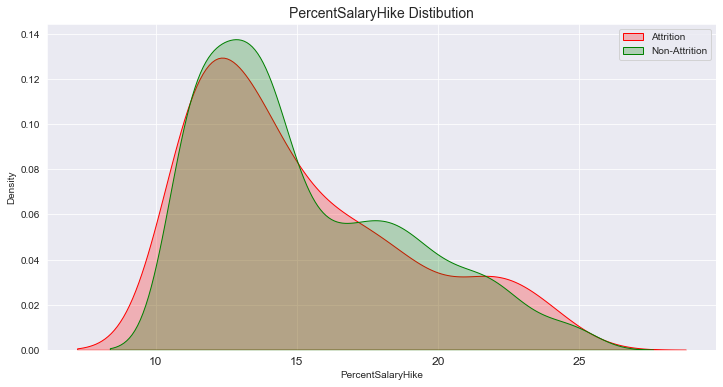

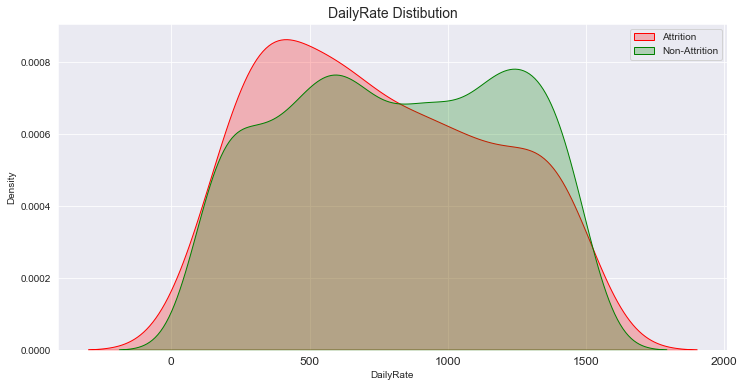

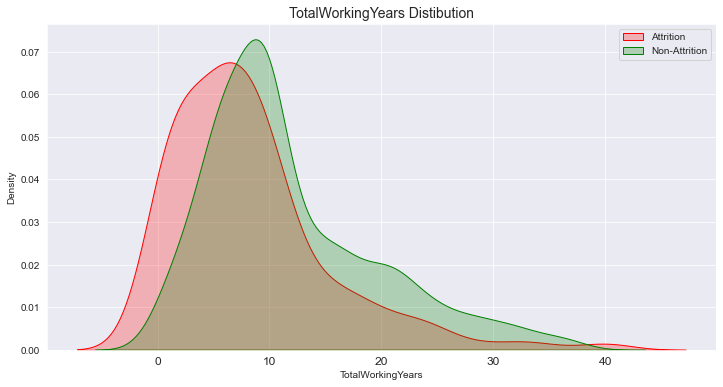

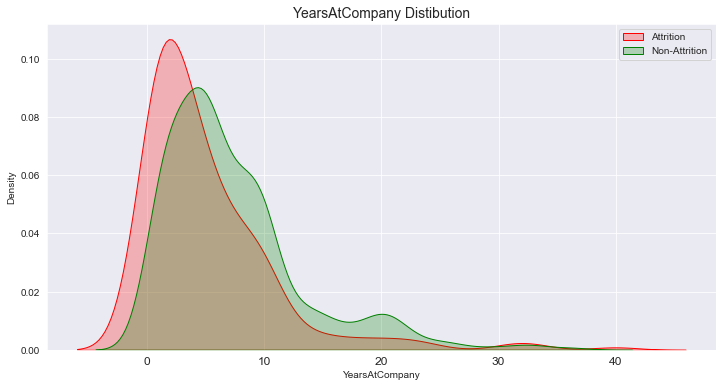

In [19]:
for feature in numeric_data_to_plot:
    plot_num_data(feature)

#### Attrition can strongly be influenced by:

* Young employees tend to suffer from attrition more often than their older colleagues. Moreover, overall life working experience and working experience in the current company play a significant role in attrition probability. Younger and less experienced workers are more likely to get attrition;

* It is pretty obvious that low salary would definitely lead to attrition sooner or later, what is clearly seen on the charts above. Employees with higher salary are less likely to suffer from attrition. Moreover, it is job involvement that makes an employee love his job. The higher the involvement - the higher the salary and consequiently worker's happines;

* One more important feature is distance from work to home that correlates with attrition. Long distance is not preferred and can cause attrition;

* DailyRate shows that if the number per day is less than 750, the worker is more likely to get attrition, compared to their colleagues with the rate above 750.

#### Lets create some final plots to see remaining interesting points in our data

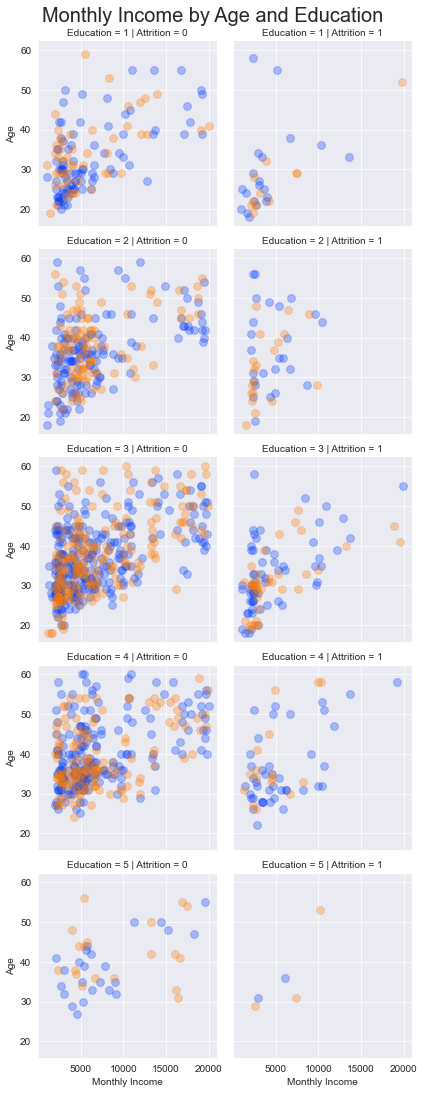

In [20]:
# create some plots to see income, age and education distribution and correlation
g = sns.FacetGrid(data=data, col="Attrition", row="Education", hue="Gender")   

g.map(plt.scatter, "MonthlyIncome", "Age", s=60, alpha=0.3)        
g.set_axis_labels("Monthly Income", "Age");
g.fig.suptitle("Monthly Income by Age and Education", y=1.01, fontsize = 20);

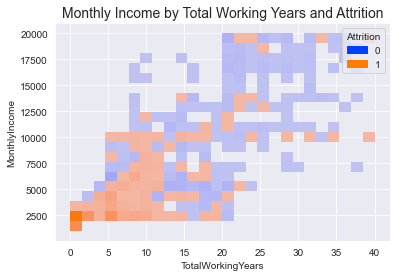

In [21]:
# complicated hist_plot shows correletion between working years + income
sns.histplot(data=data, y="MonthlyIncome", x="TotalWorkingYears", hue="Attrition")
plt.title("Monthly Income by Total Working Years and Attrition", fontsize=14);

# Data Preprocessing

#### Lets encode cotogorical columns in to numeric and check resulting correlation with Attrition

In [22]:
# use get_dummies because we don't have complicated data enough to use sklearn encoders
data_dummies = pd.get_dummies(data, drop_first=True)
data_dummies.corr()["Attrition"]

Age                                 -0.159205
Attrition                            1.000000
DailyRate                           -0.056652
DistanceFromHome                     0.077924
Education                           -0.031373
EmployeeNumber                      -0.010577
EnvironmentSatisfaction             -0.103369
HourlyRate                          -0.006846
JobInvolvement                      -0.130016
JobLevel                            -0.169105
JobSatisfaction                     -0.103481
MonthlyIncome                       -0.159840
MonthlyRate                          0.015170
NumCompaniesWorked                   0.043494
PercentSalaryHike                   -0.013478
PerformanceRating                    0.002889
RelationshipSatisfaction            -0.045872
StockOptionLevel                    -0.137145
TotalWorkingYears                   -0.171063
TrainingTimesLastYear               -0.059478
WorkLifeBalance                     -0.063939
YearsAtCompany                    

#### From the resulting data we can notice:
* That there is a correlation between BusinessTravel_Travel_Frequently and Attrition, what means - the more the employee has to travel - the more he gets tired and the risk of attrition rises; 
 
* Moreover, we can see that JobRole_Sales Representative correlates with Attrition, it may be connected with amount of stress the employee gets while working with clients;

* Some external factors may influence the propability of an employee getting an attrition, for instance: MaritalStatus_Single and OverTime_Yes.

#### Lets standardize data to get better performance of our models. Then split to train and test to check performance.

In [23]:
# prepare X and y
X_unscaled = data_dummies.drop("Attrition", axis=1)
y = data_dummies["Attrition"]

In [24]:
# scale data
scaler = StandardScaler()
X = scaler.fit_transform(X_unscaled)

In [25]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
X_train.shape, X_test.shape

((1102, 45), (368, 45))

### We are not going to use Accuracy due to the high unbalance in Attrition (1233 vs 237)

# Logistic Regression

In [27]:
# create logistic regression model and train it
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

# predict X_test and probability
pred_logreg = logreg_clf.predict(X_test)
pred_proba_logreg = logreg_clf.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_logreg))

Classification_report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       311
           1       0.67      0.42      0.52        57

    accuracy                           0.88       368
   macro avg       0.78      0.69      0.72       368
weighted avg       0.86      0.88      0.87       368



# Random Forest

In [28]:
# create random forest model and train it
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)

# predict X_test and probability
pred_randfor = random_forest_clf.predict(X_test)
pred_proba_randfor = random_forest_clf.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_randfor))

Classification_report: 
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       311
           1       0.71      0.18      0.28        57

    accuracy                           0.86       368
   macro avg       0.79      0.58      0.60       368
weighted avg       0.84      0.86      0.82       368



# GridSearchCV Random Forest

In [29]:
# create single random forest model
simple_clf = RandomForestClassifier()

# define params to try
params = params = {"n_estimators": [100, 150, 200, 250, 300], 
                   "min_samples_split": [2, 4, 6, 8], 
                   "min_samples_leaf": [1, 2, 4, 6], 
                   "max_depth": range(1, 11, 2)}

# create grid search model and fit random forest in it 
grid = GridSearchCV(simple_clf, params, cv=5, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

# take best resulting model from random search
best_clf = grid.best_estimator_

# predict X_test and probability
pred_best = best_clf.predict(X_test)
pred_proba_best = best_clf.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_best))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Classification_report: 
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       311
           1       0.83      0.18      0.29        57

    accuracy                           0.87       368
   macro avg       0.85      0.58      0.61       368
weighted avg       0.86      0.87      0.83       368



# SVC

In [30]:
# create SVC model and train it
svc_clf = SVC(kernel="linear", probability=True)
svc_clf.fit(X_train, y_train)

# predict X_test and probability
pred_svc = svc_clf.predict(X_test)
pred_proba_svc = svc_clf.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_svc))

Classification_report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       311
           1       0.64      0.40      0.49        57

    accuracy                           0.87       368
   macro avg       0.77      0.68      0.71       368
weighted avg       0.86      0.87      0.86       368



# KNN

In [31]:
# create KNN model
knn_clf = KNeighborsClassifier()

# define params to try
params = {"n_neighbors": range(1, int(np.sqrt(len(X_train)))), 
          "weights": ['uniform', 'distance']}

# create grid search model and fit KNN in it 
grid_knn = GridSearchCV(knn_clf, params, cv=5, verbose=3, n_jobs=-1)
grid_knn.fit(X_train, y_train)

# take best resulting model from random search
best_clf_knn = grid_knn.best_estimator_

# predict X_test and probability
pred_best_knn = best_clf_knn.predict(X_test)
pred_proba_knn = best_clf_knn.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_best_knn))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Classification_report: 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       311
           1       0.71      0.09      0.16        57

    accuracy                           0.85       368
   macro avg       0.79      0.54      0.54       368
weighted avg       0.83      0.85      0.80       368



#### We can try to track the changes in accuracy with different number of neighbors

In [46]:
# define a function to track accuracy vs number of neighbors
def find_neighbors(train_data):
    """
    Calculates through possible range of neighbors and tracks accuracy
    
    ...
    
    Parameters
    ----------
    train_data : pd.DataFrame
        Data to be trained on
    """
    
    # define some variables for easier use
    accuracy = {}
    start = 1
    end = int(np.sqrt(len(train_data)))
    
    # go through every possible naighbor
    for num in range(start, end + 1):
        neighbors = num + 1
        
        # create and train model
        model = KNeighborsClassifier(n_neighbors=neighbors, weights="uniform")
        model.fit(X_train , y_train)
        
        # predict X_test and probability
        pred_knn = model.predict(X_test)
        knn_accuracy = accuracy_score(y_test, pred_knn)
        
        # update dictionary to see results
        accuracy.update({num: knn_accuracy})
    return accuracy


# track neighbors and accuracy
accuracy = find_neighbors(X_train)

print("KNN best score:", max(accuracy.values()))

KNN best score: 0.8559782608695652


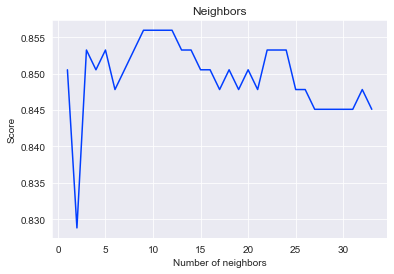

In [47]:
# define function to plot KNN's accuracy
def plot_accuracy(dictionary):
    """
    Plots accuracy on given dictionary of data
    
    ...
    
    Parameters
    ----------
    dictionary : dict()
        Dictionary to use for plotting data
    """
    
    data = pd.Series(dictionary, index=dictionary.keys())
    data.plot()
    plt.title("Neighbors")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Score")


plot_accuracy(accuracy)

# Naive Bayes

In [35]:
# create Bayes model and train it
bayes_clf = GaussianNB()
bayes_clf.fit(X_train, y_train)

# predict X_test and probability
pred_bayes = bayes_clf.predict(X_test)
pred_proba_bayes = bayes_clf.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_bayes))

Classification_report: 
               precision    recall  f1-score   support

           0       0.94      0.67      0.78       311
           1       0.29      0.75      0.42        57

    accuracy                           0.68       368
   macro avg       0.62      0.71      0.60       368
weighted avg       0.84      0.68      0.73       368



# XGBoost

#### To use XGB we need to define validetion set of data

In [36]:
X_train_xgb, X_valid, y_train_xgb, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [37]:
# create Bayes model and train it
clf_xgb = XGBClassifier(n_estimators=500, 
                        learning_rate=0.1, 
                        max_depth=8, 
                        min_child_weight=1, 
                        gamma=1,
                        n_jobs=-1, 
                        random_state=42, 
                        use_label_encoder=False, 
                        eval_metric="logloss")
clf_xgb.fit(X_train_xgb, y_train_xgb, early_stopping_rounds=50, eval_set=[(X_valid, y_valid)], verbose=False)

# predict X_test and probability
pred_xgb = clf_xgb.predict(X_test)
pred_proba_xgb = clf_xgb.predict_proba(X_test)

print("Classification_report:", "\n", classification_report(y_test, pred_xgb))

Classification_report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       311
           1       0.74      0.25      0.37        57

    accuracy                           0.87       368
   macro avg       0.81      0.61      0.65       368
weighted avg       0.86      0.87      0.84       368



# Plotting Results

In [48]:
# define a function that will plot ROC-AUC-SCORES
def roc_auc_plotter(pred, pred_proba, label=""):
    """
    Plots roc_auc_curve on selected data
    
    ...
    
    Parameters
    ----------
    pred : np.array
        Array of predicted values
    pred_proba : np.array
        Array of predicted probabilities
    label : str
        Label to use with model
    """
    
    clf_roc_auc = roc_auc_score(y_test, pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
    ax.plot(fpr, tpr, label=f"{label} (area = %0.2f)" % clf_roc_auc)
    
    ax.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic", fontsize=14)
    plt.legend(loc="lower right");

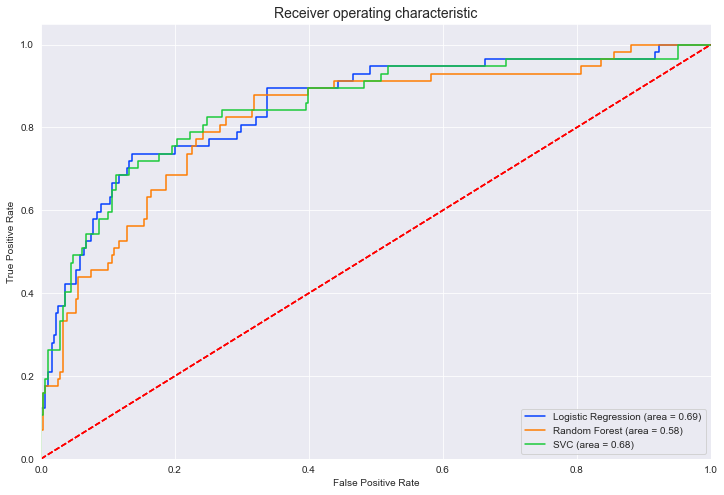

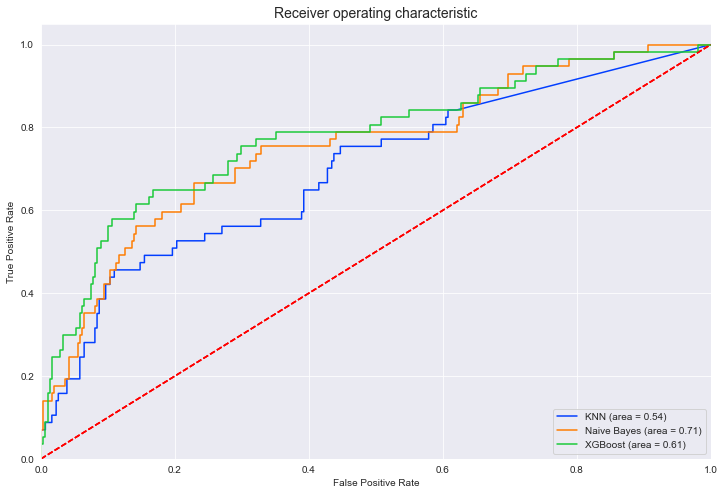

In [39]:
# plot first three models and compare
fig, ax = plt.subplots(figsize=(12, 8))
roc_auc_plotter(pred_logreg, pred_proba_logreg, label="Logistic Regression")
roc_auc_plotter(pred_best, pred_proba_best, label="Random Forest")
roc_auc_plotter(pred_svc, pred_proba_svc, label="SVC")

# plot remaining three models and compare
fig, ax = plt.subplots(figsize=(12, 8))
roc_auc_plotter(pred_best_knn, pred_proba_knn, label="KNN")
roc_auc_plotter(pred_bayes, pred_proba_bayes, label="Naive Bayes")
roc_auc_plotter(pred_xgb, pred_proba_xgb, label="XGBoost")

# Comparing Results

In [40]:
# get models' names
clfs = ["Logistic_Regression", "Random_Forest", "Best_Random_Forest", "SVC", "KNeighbors", "Naive Bayes", "XGBoost"]

# track list of models 
models = [logreg_clf, random_forest_clf, best_clf, svc_clf, best_clf_knn, bayes_clf, clf_xgb]

# track recall score
Recall_score = [recall_score(y_test, model.predict(X_test)) for model in models]

# track precision score
Precision_score = [precision_score(y_test, model.predict(X_test)) for model in models]

# track f1 score
F1_score = [f1_score(y_test, model.predict(X_test)) for model in models]

# track roc auc score
Roc_auc_score = [roc_auc_score(y_test, model.predict(X_test)) for model in models]

# create dataframe with scores
model_performance = pd.DataFrame({"Precision_score": Precision_score, 
                                  "Recall_score": Recall_score, 
                                  "F1_score": F1_score,
                                  "Roc_auc_score": Roc_auc_score}, index=clfs)

In [41]:
model_performance

,Precision_score,Recall_score,F1_score,Roc_auc_score
Logistic_Regression,0.666667,0.421053,0.516129,0.691234
Random_Forest,0.714286,0.175439,0.281690,0.581288
Best_Random_Forest,0.833333,0.175439,0.289855,0.584504
SVC,0.638889,0.403509,0.494624,0.680854
KNeighbors,0.714286,0.087719,0.156250,0.540644
Naive Bayes,0.294521,0.754386,0.423645,0.711598
XGBoost,0.736842,0.245614,0.368421,0.614768


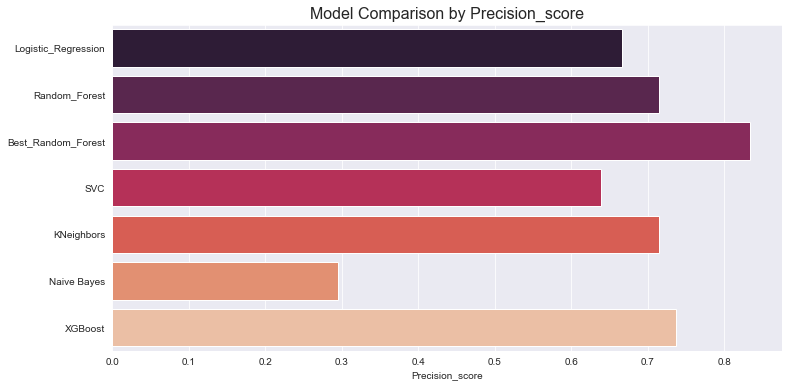

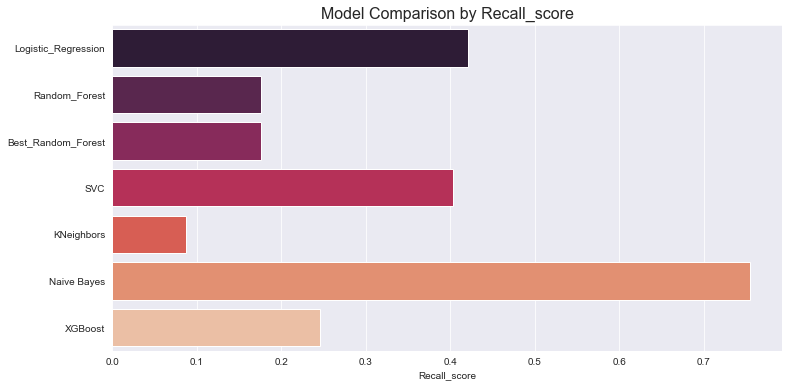

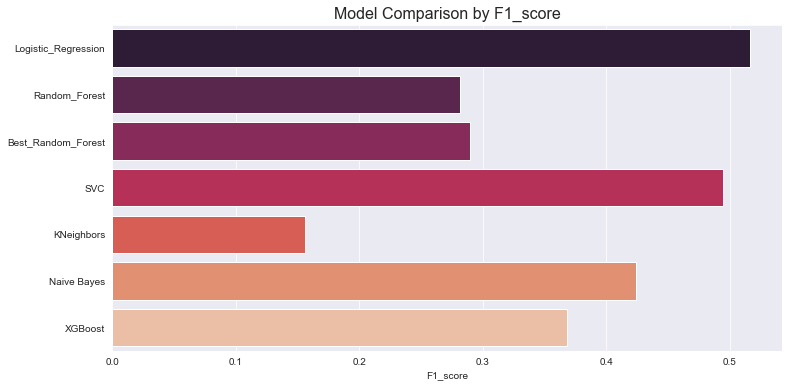

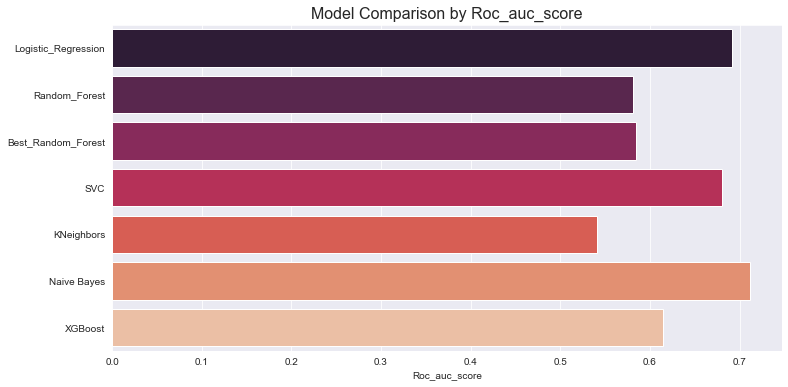

In [49]:
# define a function to plot models' results
def compare_models(col_name):
    """
    Plots barplots on selected data
    
    ...
    
    Parameters
    ----------
    col_name : list()
        Columns to plot
    """
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=model_performance, x=col_name, y=model_performance.index, palette="rocket")
    plt.title(f"Model Comparison by {col_name}", fontsize=16)
    
for metric in list(model_performance):
    compare_models(metric)

#### Summary:

* Precision score: Grid Search Random Forest Classifier gained best result (0.818). XGBClassifier also did well (0.737), but the rest of the models didn't show such results. Naive Bayes got less than 0.3;

* Recall score: Naive Bayes became a complete winner with the result of 0.754. Other models were not even close;

* F1 score: Logistic Regression and linear SVC are the leaders with scores of 0.516 and 0.495 respectively. The rest of the models can't be proud of their results;

* Roc auc score: Naive Bayes and Logistic Regression are the leaders as well with scores of 0.712 and 0.691 respectively. SVC got almost the same results as Logistic Regression (0.681).